## Using updated libraries and packages

In [ ]:
!pip install --upgrade lightgbm
!pip install --upgrade sklearn

     |████████████████████████████████| 1.8MB 4.2MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir input_data
!unzip "/content/gdrive/My Drive/cgiar agricultural zindi.zip" -d "/content/input_data"
## Unzipping the contents to the input folder 
!unzip '/content/input_data/cgiar agricultural zindi/image_arrays_train.zip' -d '/content/input_data/cgiar agricultural zindi'
!unzip '/content/input_data/cgiar agricultural zindi/image_arrays_test.zip' -d '/content/input_data/cgiar agricultural zindi'

Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/cgiar agricultural zindi.zip
  inflating: /content/input_data/cgiar agricultural zindi/bandnames.txt  
  inflating: /content/input_data/cgiar agricultural zindi/fields_w_additional_info.csv  
 extracting: /content/input_data/cgiar agricultural zindi/image_arrays_test.zip  
 extracting: /content/input_data/cgiar agricultural zindi/image_arrays_train.zip  
  inflating: /content/input_data/cgiar agricultural zindi/ImageBands.docx  
  inflating: /content/input_data/cgiar agricultural zindi/SampleSubmission.csv  
  inflating: /content/input_data/cgiar agricultural zindi/Starter_Notebook_CGIAR_Yield_Estimation (1).ipynb  
  inflating: /content/input_data/cgiar agricultural zindi/Starter_Notebook_CGIAR_Yield_Estimation.ipynb  
  inflating: /content/input_data/cgiar agricultural zindi/test_field_ids_with_year.csv  
  inflating: /content/input_data/cgiar agricultural zindi/Train.csv  
Archive:  /content/input_data/cgiar agricultural 

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Step 1:- Data Load process
Here we import the train and test dataset. <br>
The quality=1 records are removed from the train dataset.
<br>
<b>The value counts corresponding to each year in train data</b> <br>
2017    0.410266 <br>
2016    0.343652 <br>
2019    0.183386 <br>
2018    0.062696 <br>

<b> The value counts corresponding to each year in test data</b> <br>
2017    0.407583 <br>
2016    0.315640 <br>
2019    0.186730 <br>
2018    0.090047 <br>

We drop the Quality column from the train because it wont be needed after subsetting 

In [ ]:
train_df          = pd.read_csv('/content/input_data/cgiar agricultural zindi/Train.csv')
train_df_cpy      = train_df.copy()
test_df           = pd.read_csv('/content/input_data/cgiar agricultural zindi/SampleSubmission.csv')
test_df_with_year = pd.read_csv('/content/input_data/cgiar agricultural zindi/test_field_ids_with_year.csv')
train_df          = train_df[train_df['Quality']!=2]
test_df           = pd.merge(test_df,test_df_with_year,on=['Field_ID'])
train_df          = train_df.drop(['Quality'],axis=1)


band_names        = [l.strip() for l in open('/content/input_data/cgiar agricultural zindi/bandnames.txt', 'r').readlines()]

# print(train_df.Year.value_counts()/train_df.shape[0])
# print(test_df.Year.value_counts()/test_df.shape[0])
print(train_df.shape,test_df.shape)
train_df.head(2)

(1746, 3) (1055, 3)


,Field_ID,Year,Yield
0,MH2O0YH,2019,3.686
2,35AFSDD,2019,3.082


## Additional dataset Features
Here we create year and soil specific features from the additional dataset given. We create some functions to extract those year specific features and then use them corresponding to field ids.

In [ ]:
extra_dataframe = pd.read_csv('/content/input_data/cgiar agricultural zindi/fields_w_additional_info.csv')
### Here we load the additional dataset given with extra features

In [ ]:
def extract_year_specific_features(year):
  '''
      Computes year specific data from the extra data given for each Field ID to be used for joining
  '''
  cols_extra        = extra_dataframe.columns.tolist()
  climate_year_cols = [t for t in cols_extra if t.startswith(f'climate_{year}')]
  ### The climate specific years to extract like climate_2018_1_aet, climate_2018_2_def etc 
  soil_components        = [t for t in cols_extra if t.startswith('soil_')]
  ### The soil specific components (that are independent of years and climate)

  year_spec_df      = extra_dataframe[['Field_ID']+climate_year_cols+soil_components]
  columns           = year_spec_df.columns.tolist()

  rename_cols       = [col.replace(f'climate_{year}_',"") for col in columns]
  ### New columns renamed so that 'climate_year_' is removed from column name and we have only features

  year_spec_df      = year_spec_df.rename(columns=dict(zip(columns,rename_cols)))
  ### year specific extra data to be used

  return year_spec_df

def enter_year(year):
  '''
      We enter the year and then left join the existing data with the extra features given
  '''
  year_specific_data = extract_year_specific_features(year)
  train_year_spec    = train_df[train_df['Year']==year].merge(year_specific_data,on=['Field_ID'])
  test_year_spec     = test_df[test_df['Year']==year].merge(year_specific_data,on=['Field_ID'])
  return train_year_spec,test_year_spec

def get_train_test_dict():
  '''
      Year specific dictionary for each train and test dataset.
      The key corresponds to year and values are specific dataframes 
  '''
  year_train_dict = {}
  year_test_dict  = {}
  for year in [2016,2017,2018,2019]:
    year_train_dict[year],year_test_dict[year] = enter_year(year)
  return year_train_dict,year_test_dict


def get_data(input_dict):
  '''
      Getting the train and test data with additional features 
  '''
  count = 0
  for key,values in input_dict.items():
    if count ==0:
      df = values
    else:
      df = df.append(values,ignore_index=True)
    count = count+1
  return df

In [ ]:
year_train_dict,year_test_dict = get_train_test_dict()
new_train                      = get_data(year_train_dict)
new_test                       = get_data(year_test_dict)
new_train.shape,train_df.shape,new_test.shape,test_df.shape

((1746, 182), (1746, 3), (1055, 182), (1055, 3))

# STEP 2:- Preprocessing of data

## Helper Functions
Here we develop a few helper functions to help in data extraction and feature engineering process

In [ ]:
def Extract_arr(month,fid,train=True):
  '''
      Helper function to get the image array corresponding to each fid.
      We attain the field id array (shape of the array (360,40,41)). 360 is 30 bands for 12 months. (40,41) will be 
      size of black and white image attained for that month
  '''
  if train:
    src = 'image_arrays_train'
  else:
    src = 'image_arrays_test'
  folder = f'/content/input_data/cgiar agricultural zindi/{src}/{fid}.npy'
  arr    = np.load(folder)
  return arr

def get_bands_interest(month,band):
  '''
      Helper function to use bands of interest to extract Sentinel 2 bands corresponding to a given month.
  '''
  source  = 'S2'
  month   = str(month)
  bn      = [month+'_'+source+'_'+band]
  indexes = np.where(np.isin(band_names,bn))
  return indexes


def get_bands_interest_clim(month,band):
  '''
      Helper function to use bands of interest from terraclim corresponding to a given month
  '''
  source  = 'CLIM'
  month   = str(month)
  bn      = [month+'_'+source+'_'+band]
  indexes = np.where(np.isin(band_names,bn))
  return indexes


def get_statistics(array,operation,ranges = (0.5,np.inf)):
  '''
      Used to find the type of operation/aggregation to be performed on a given array.
      The available operations are :- 
      'max'           :- To find the maximum of a given 2d array
      'min'           :- To find the minimum value in a given 2d array
      'mean'          :- To find the mean/average value of a given 2d array
      'between_range' :- To find the proportion of values in a given range
      'midfield'      :- To find the values in the middle of the image (It was given that the centre of image is the image location)

      Note:- More functions can be added here to make it customizable in future. 
             This function will be used in 'calculate_statistics_band' function 
  '''
  if operation =='max':
    return np.max(array)
  elif operation == 'min':
    return np.min(array)
  elif operation=='mean':
    return np.mean(array)
  elif operation=='between_range':
    return array_range_percent(array,ranges)
  elif operation == 'midfield':
    return array[0][20,20]


def array_range_percent(array,ranges):
  '''
      To get percentage of values within a given range.
      The input parameters are :- array(numpy array) and ranges (tuple suggesting a lower and upper bound example - ranges = (0.6,0.8))
  '''
  lower_bound = ranges[0]
  upper_bound = ranges[1]
  return (array[np.where((array<upper_bound)&(array>=lower_bound))].shape[0])/(array[0].shape[1]*array[0].shape[0])


def calculate_statistics_band(month,fid,train,functionality_index,operation,ranges=(0.5,np.inf)):
  ''' 
      This is a utility function to calculate various index-based statistics (like mean of AFRI, middle point of NDVI etc).
      It takes the help of function - 'get_statistics' defined above and computes statistics for each month for a particular Field ID 
      corresponding to train/test. 

      The parameters are :-
      month     :- month for which the operation/statistics is needed
      fid       :- Field ID
      train     :- Whether the data is in train folder or test folder
      operation :- Can be min, max,mean,between_range etc
      ranges    :- To be entered only when operation='between_range'
      functionality_index :- Function to be considered for index calculation (like compute_monthly_ndvi etc). A list of functionality indices are declared below.
  '''
  array = functionality_index(month,fid,train)
  return get_statistics(array,operation,ranges) 

def perform_eda_metric(fn,fid,train=True,save=False,quality=1):
  '''
      Performs the Monthly plot EDA corresponding to a specific index for a given Field ID
  '''
  metric = []
  for i in range(12):
    metric.append(fn(i,fid,train)[0])
  fig,axis = plt.subplots(4,3,figsize=(15,15),facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = .5, wspace=.001)
  count = 0
  for i in range(0,12,3):
    for j in range(3):
      k = i+j
      axis[count,j].imshow(metric[k],cmap="RdYlGn",interpolation='gaussian');
      axis[count,j].set_title(f'Month-{k}')
    count = count+1
  if save:
    if train:
      fig.savefig(f'/content/gdrive/MyDrive/cgiar_images_train/{quality}/ndvi_{fid}.png')
    else:
      fig.savefig(f'/content/gdrive/MyDrive/cgiar_images_test/ndvi_{fid}.png')
  return 





## Sentinel 2 indices
These indices have been calculated after understanding them from the link :- https://custom-scripts.sentinel-hub.com/#sentinel-2
We were abel to get a rough idea of which ones to consider for Kenya using this link :- http://web.pdx.edu/~nauna/resources/8-2012_lecture1-vegetationindicies.pdf

Even though there were an exhaustive list of indices we coded, we present the only relevant ones here that we selected over the course of 2 months and seeing feature importance of each of the other indices calculated.

Note :- We had to exclude some indices related to chlorophyll content in crops (like GCI, Enhanced Vegetation Indices (EVI) etc.) even after studying that they are very important in crop yield analysis. 
Those functions can be coded in the same format as below and can be used as and when needed. We present only the indices which we used in our analysis of this problem 

In [ ]:
def Bands_as_is(month,fid,train=True):
  '''
      Get the bands as is from sentinel 2 having middle values
  '''
  arr   = Extract_arr(month,fid,train)
  arr   = np.float_(arr)
  bands_dict = {}
  #bands_dict[str(month+1)+'_'+'B1'] = arr[get_bands_interest(month,'B1')][0][20,20]
  bands_dict[str(month+1)+'_'+'B2'] = arr[get_bands_interest(month,'B2')][0][20,20]
  bands_dict[str(month+1)+'_'+'B3'] = arr[get_bands_interest(month,'B3')][0][20,20]
  # bands_dict[str(month+1)+'_'+'B4'] = arr[get_bands_interest(month,'B4')][0][20,20]
  bands_dict[str(month+1)+'_'+'B5'] = arr[get_bands_interest(month,'B5')][0][20,20]
  bands_dict[str(month+1)+'_'+'B6'] = arr[get_bands_interest(month,'B6')][0][20,20]
  bands_dict[str(month+1)+'_'+'B7'] = arr[get_bands_interest(month,'B7')][0][20,20]
  # bands_dict[str(month+1)+'_'+'B8'] = arr[get_bands_interest(month,'B8')][0][20,20]
  bands_dict[str(month+1)+'_'+'B9'] = arr[get_bands_interest(month,'B9')][0][20,20]
  # bands_dict[str(month+1)+'_'+'B10'] = arr[get_bands_interest(month,'B10')][0][20,20]
  # bands_dict[str(month+1)+'_'+'B11'] = arr[get_bands_interest(month,'B11')][0][20,20]
  # bands_dict[str(month+1)+'_'+'B12'] = arr[get_bands_interest(month,'B12')][0][20,20]
  return bands_dict


def NDVI_compute(month,fid,train=True):
  '''
    Normalized Difference Vegetation Index is calculated in accordance with the formula:- 
    NDVI = (NIR-RED)/(NIR+RED)
    NIR :- reflection in near infrared spectrum
    RED :- reflection in red range of spectrum
    This is called calibrated NDVI.
    Ideal values must be between 0.6 to 1. Anything below 0 is no vegetation. 
    Anything between 0 to 0.5 is partial vegetation

  '''
  arr   = Extract_arr(month,fid,train)
  arr   = np.float_(arr)
  b8    = arr[get_bands_interest(month,'B8')]
  b4    = arr[get_bands_interest(month,'B4')]

  ndvi  = ((b8-b4)/(b8+b4))
  return ndvi

def NDWI_compute(month,fid,train=True):
  '''
      This is normalized difference water index used to monitor changes in water content in leaves 
      using Near InfraRed values and Short Wave Infrared Wavelengths (proposed by Gao in 1996)
      NDWI = (NIR - MIR)/ (NIR + MIR)
      the ranges below 0 indicates bright surfaces with no vegetation or water content
      
  '''
  arr   = Extract_arr(month,fid,train)
  arr   = np.float_(arr)
  b8    = arr[get_bands_interest(month,'B8')]
  b12   = arr[get_bands_interest(month,'B12')]

  ndwi  = ((b8-b12)/(b8+b12))
  return ndwi


def DVI_compute(month,fid,train=True):
  '''
      This index distinguishes between soil and vegetation, but it
      does not account for the difference between reflectance and radiance 
      caused by atmospheric effects or shadows.
  '''
  arr    = Extract_arr(month,fid,train)
  arr    = np.float_(arr)
  b8     = arr[get_bands_interest(month,'B8')]
  b4     = arr[get_bands_interest(month,'B4')]
  dvi    = b8-b4
  return dvi


def AFRI_compute(month,fid,train=True):
  '''
      This is Aerosol Free Vegetation Index. It is used as a measure to check pollution index (smoke and sulphate levels in 
      atmosphere). High value may result in poor quality crops.
      AFRI = NIR - (0.66*SWIR/(NIR+0.66*SWIR))
  '''
  arr    = Extract_arr(month,fid,train)
  arr    = np.float_(arr)
  b8     = arr[get_bands_interest(month,'B8')]
  b11    = arr[get_bands_interest(month,'B11')]
  afri   = b8-((0.66*b11)/(b8+0.66*b11))
  return afri

def BNDVI_compute(month,fid,train=True):
  '''
      This is Normalized Difference NIR/Blue Blue-normalized difference vegetation index
      Formula = (NIR-BLUE)/(NIR+BLUE)
  '''
  arr    = Extract_arr(month,fid,train)
  arr    = np.float_(arr)
  b8     = arr[get_bands_interest(month,'B8')]
  b2     = arr[get_bands_interest(month,'B2')]
  bndvi  = (b8-b2)/(b8+b2)
  return bndvi

def NLI_compute(month,fid,train=True):
  '''
      This is Non Linear Vegetation index having formula :- ((NIR)^2 - RED)/((NIR)^2 + RED)
  '''
  arr    = Extract_arr(month,fid,train)
  arr    = np.float_(arr)
  b8     = arr[get_bands_interest(month,'B8')]
  b4     = arr[get_bands_interest(month,'B4')]
  nli    = ((b8**2)-b4)/((b8**2)+b4)
  return nli



def VI700_compute(month,fid,train=True):
  '''
      This is vegetation index with formula (red_edge1-red)/(red_edge1+red)
  '''
  arr    = Extract_arr(month,fid,train)
  arr    = np.float_(arr)
  b5     = arr[get_bands_interest(month,'B5')]
  b4     = arr[get_bands_interest(month,'B4')]
  vi     = (b5-b4)/(b5+b4)
  return vi
  
def Band_return(month,fid,input_band,train=True,):
  ''' 
      Returns the band array corresponding to a given field id in a given month 
  '''
  arr    = Extract_arr(month,fid,train)
  arr    = np.float_(arr)
  return arr[get_bands_interest(month,input_band)]

## Testing the values and performing some EDA

In [ ]:
def tester(function,k):
  '''
      This function is used for visualization purpose only. It helped us in selecting which indices to pick and which ones to discard
  '''
  print(f"Yield for the record:-{train_df_cpy['Yield'].values[k]}")
  print(f"Quality for the record:-{train_df_cpy['Quality'].values[k]}")
  for month in range(12):
    print(f'Calculating for month-{month}:- ')
    rangepct = get_statistics(function(month,train_df_cpy['Field_ID'].values[k],True),'between_range',(3.5,5.5))
    max      = get_statistics(function(month,train_df_cpy['Field_ID'].values[k],True),'max')
    min      = get_statistics(function(month,train_df_cpy['Field_ID'].values[k],True),'min')
    mean     = get_statistics(function(month,train_df_cpy['Field_ID'].values[k],True),'mean')
    mid_val  = get_statistics(function(month,train_df_cpy['Field_ID'].values[k],True),'midfield')
    print(f"Rangepct :- {rangepct}, Max :- {max}, Min :- {min}, Mean :- {mean}, Middle field:- {mid_val}")
    print('\n')
  perform_eda_metric(NDVI_compute,new_train['Field_ID'].values[k],True)
  return

Yield for the record:-5.039
Quality for the record:-3
Calculating for month-0:- 
Rangepct :- 0.0, Max :- 0.6045454545454545, Min :- 0.18259963532169837, Mean :- 0.38701340225832, Middle field:- 0.3413447782546495


Calculating for month-1:- 
Rangepct :- 0.0, Max :- 0.622946093975209, Min :- 0.14265799256505576, Mean :- 0.3345239830881619, Middle field:- 0.28034603947012704


Calculating for month-2:- 
Rangepct :- 0.0, Max :- 0.5929847782925215, Min :- 0.14614918132201335, Mean :- 0.3156444204495945, Middle field:- 0.1793265465935787


Calculating for month-3:- 
Rangepct :- 0.0, Max :- 0.6500432401268377, Min :- 0.11651090342679128, Mean :- 0.32921174604806414, Middle field:- 0.18391959798994975


Calculating for month-4:- 
Rangepct :- 0.0, Max :- 0.8331625333060053, Min :- 0.2909979064898814, Mean :- 0.6420158066661004, Middle field:- 0.735373054213634


Calculating for month-5:- 
Rangepct :- 0.0, Max :- 0.7498856881572931, Min :- 0.16080470781442452, Mean :- 0.49979016286268557, Middl

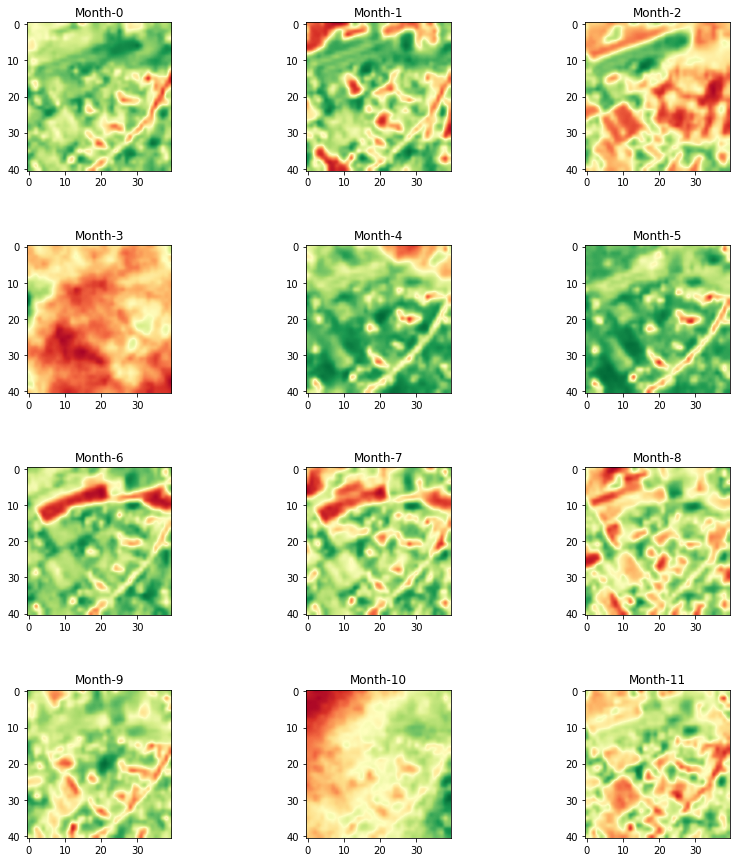

In [ ]:
### We pick a randon observation and visualizing it 
tester(NDVI_compute,9)

## Computing monthwise indices value

Here we start the preparation of the actual train and test dataset 

In [ ]:
def compute_monthwise_indices(month,z,train):
  '''
      We compute the indices for each month for a given FID.
  '''
  if train==True:
    bands_dict = {}
    bands_dict[str(month+1)+'_NDVI_MID']   = calculate_statistics_band(month,z,True,NDVI_compute,'midfield')
    bands_dict[str(month+1)+'_NDWI_MID']   = calculate_statistics_band(month,z,True,NDWI_compute,'midfield')
    bands_dict[str(month+1)+'_AFRI_MID']   = calculate_statistics_band(month,z,True,AFRI_compute,'midfield')
    bands_dict[str(month+1)+'_BNDVI_MID']  = calculate_statistics_band(month,z,True,BNDVI_compute,'midfield')
    bands_dict[str(month+1)+'_NLI_MID']    = calculate_statistics_band(month,z,True,NLI_compute,'midfield')
    bands_dict[str(month+1)+'_VI_MID']     = calculate_statistics_band(month,z,True,VI700_compute,'midfield')
    return bands_dict
  else:
    bands_dict = {}
    bands_dict[str(month+1)+'_NDVI_MID']   = calculate_statistics_band(month,z,False,NDVI_compute,'midfield')
    bands_dict[str(month+1)+'_NDWI_MID']   = calculate_statistics_band(month,z,False,NDWI_compute,'midfield')
    bands_dict[str(month+1)+'_AFRI_MID']   = calculate_statistics_band(month,z,False,AFRI_compute,'midfield')
    bands_dict[str(month+1)+'_BNDVI_MID']  = calculate_statistics_band(month,z,False,BNDVI_compute,'midfield')
    bands_dict[str(month+1)+'_NLI_MID']    = calculate_statistics_band(month,z,False,NLI_compute,'midfield')
    bands_dict[str(month+1)+'_VI_MID']     = calculate_statistics_band(month,z,False,VI700_compute,'midfield')
    return bands_dict


##  Monthwise feature set generation
Here we will be finding out the monthwise indices, their corresponding Sentinel 2 features and terraclim indices and put all the relevant features corresponding to one month in one dictionary(to be concatenated later) 

Since this step uses all the functions above, it will take about 10 mins to run (max)

In [ ]:
def calculate_final_data(month):
  '''
      Creates the monthwise train and test dataset
  '''
  ### bandwise sentinel 2 data (calculated for given month)
  train_bands             = pd.DataFrame([Bands_as_is(month,fid,True) for fid in new_train['Field_ID'].values])
  train_bands['Field_ID'] = new_train['Field_ID']
  test_bands              = pd.DataFrame([Bands_as_is(month,fid,False) for fid in new_test['Field_ID'].values])
  test_bands['Field_ID']  = new_test['Field_ID']
  print('Bandwise values extracted')
  ### Sentinel 2 indices (calculated for given month) 
  sentinel_ind_train      = pd.DataFrame([compute_monthwise_indices(month,fid,True) for fid in new_train['Field_ID'].values])
  sentinel_ind_train['Field_ID'] = new_train['Field_ID']
  sentinel_ind_test      = pd.DataFrame([compute_monthwise_indices(month,fid,False) for fid in new_test['Field_ID'].values])
  sentinel_ind_test['Field_ID'] = new_test['Field_ID']
  
  print('Monthwise sentinel 2 indices extracted')

  
  soil_ind       = ['soil_ocd_5-15cm_mean','soil_silt_5-15cm_mean','soil_cec_5-15cm_mean']
  
  monthly_ind    = [f'{month+1}_swe', f'{month+1}_soil', f'{month+1}_tmmn',f'{month+1}_def', f'{month+1}_pdsi']

  needed_train   = new_train[soil_ind+monthly_ind+['Field_ID']]
  needed_test    = new_test[soil_ind+monthly_ind+['Field_ID']]
  print('Terraclim values extracted along with soil values.')

  month_train    = needed_train.merge(train_bands, how='left',on='Field_ID')
  month_train    = month_train.merge(sentinel_ind_train,how='left',on='Field_ID')

  month_test     = needed_test.merge(test_bands, how='left',on='Field_ID')
  month_test     = month_test.merge(sentinel_ind_test,how='left',on='Field_ID')
  
  month_train['Yield'] = new_train.Yield
  return month_train,month_test

In [ ]:
train_dict = {}
test_dict  = {}
months2consider = [0,1,2,3,4,7,11]
for i in months2consider:
  print(i)
  train_dict[i],test_dict[i] = calculate_final_data(i)

0
Bandwise values extracted
Monthwise sentinel 2 indices extracted
Terraclim values extracted along with soil values.
1
Bandwise values extracted
Monthwise sentinel 2 indices extracted
Terraclim values extracted along with soil values.
2
Bandwise values extracted
Monthwise sentinel 2 indices extracted
Terraclim values extracted along with soil values.
3
Bandwise values extracted
Monthwise sentinel 2 indices extracted
Terraclim values extracted along with soil values.
4
Bandwise values extracted
Monthwise sentinel 2 indices extracted
Terraclim values extracted along with soil values.
7
Bandwise values extracted
Monthwise sentinel 2 indices extracted
Terraclim values extracted along with soil values.
11
Bandwise values extracted
Monthwise sentinel 2 indices extracted
Terraclim values extracted along with soil values.


Concatenating the entire feature set corresponding to train and test.
Here we concatenate all the monthwise features to one dataset for train and test

In [ ]:
months2consider = [0,1,2,3,4,7,11]
count = 0 
for month in months2consider:
  
  train_df = train_dict[month]
  test_df  = test_dict[month]
  target_y = train_df['Yield']
  fid2use  = test_df.Field_ID.values
  train_df = train_df.drop(['Field_ID','Yield'],axis=1)
  test_df  = test_df.drop(['Field_ID'],axis=1)
  print(f'Month :- {month+1}, train data shape :- {train_df.shape}, test data shape :- {test_df.shape}')

  if count ==0:
    train = train_df.values
    test  = test_df.values
    train_y = target_y.values
  else:
    train1 = train_df.values
    test1  = test_df.values

    train  = np.hstack((train,train1))
    test   = np.hstack((test,test1))
    train_y = target_y.values
  count = count+1


Month :- 1, train data shape :- (1746, 20), test data shape :- (1055, 20)
Month :- 2, train data shape :- (1746, 20), test data shape :- (1055, 20)
Month :- 3, train data shape :- (1746, 20), test data shape :- (1055, 20)
Month :- 4, train data shape :- (1746, 20), test data shape :- (1055, 20)
Month :- 5, train data shape :- (1746, 20), test data shape :- (1055, 20)
Month :- 8, train data shape :- (1746, 20), test data shape :- (1055, 20)
Month :- 12, train data shape :- (1746, 20), test data shape :- (1055, 20)


In [ ]:
## FInal shape
train.shape,test.shape

((1746, 140), (1055, 140))

# STEP 3:- Final Step - Model development 

We used a lightgbm model and tuned the parameters using optuna and since the entire tuning process was a bit messy, we present only the relevant parameters to get the desired results.

## Results shared with the moderators and hence can't share the model development code but here is the procedure:-
1. Train/test split
2. Regressor model
3. Output